# Using `pyirf` to calculate IRFs from the FACT Open Data


**Note** In FACT, we used a different terminology, partly because of being a monoscopic telescope or out of confusion witht the CTA terms, in this context DL3 are reconstructed events, but not necessarily already with the IRF

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

/opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/traitlets/traitlets.py:3258: FutureWarning: --rc={'figure.dpi': 300} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  warn(


## Download Data

In [3]:
! curl -z gamma_test_dl3.hdf5 -fLO https://factdata.app.tu-dortmund.de/dl3/FACT-Tools/v1.1.2/gamma_test_dl3.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0  148M    0  193k    0     0   108k      0  0:23:22  0:00:01  0:23:21  108k

  6  148M    6 9448k    0     0  3444k      0  0:00:44  0:00:02  0:00:42 3443k

 18  148M   18 27.0M    0     0  7473k      0  0:00:20  0:00:03  0:00:17 7471k

 30  148M   30 44.8M    0     0  9853k      0  0:00:15  0:00:04  0:00:11 9851k

 42  148M   42 63.4M    0     0  11.1M      0  0:00:13  0:00:05  0:00:08 12.7M

 54  148M   54 81.4M    0     0  12.2M      0  0:00:12  0:00:06  0:00:06 16.6M

 67  148M   67 99.2M    0     0  12.9M      0  0:00:11  0:00:07  0:00:04 18.2M

 80  148M   80  118M    0     0  13.6M      0  0:00:10  0:00:08  0:00:02 18.4M

 92  148M   92  136M    0     0  14.1M      0  0:00:10  0:00:09  0:00:01 18.3M

100  148M  100  148M    0     0  14.3M      0  0:00:10  0:00:10 --:--:-- 18.2M


## Read in the data


In [4]:
from astropy.table import QTable
import astropy.units as u
import tables

### Simulated Event Info

Currently, pyirf only works with powerlaw simulated events, like CORSIKA does it.
We want to also support arbitrary histograms / event distributions, but that is not yet implemented.

This can be created from a file with that information, but I will just create it here.

In [5]:
from pyirf.simulations import SimulatedEventsInfo

simulation_info = SimulatedEventsInfo(
    energy_min=200 * u.GeV,
    energy_max=50 * u.TeV,
    spectral_index=-2.7,
    n_showers=12600000,
    max_impact=300 * u.m,
    viewcone=0 * u.deg,
)

### DL2 Event List


`pyirf` does not prescribe or use a specific DL2 *file* format.
You need to read the data into an `astropy.table.QTable` following our conventions, detailed in the docs here: 

https://cta-observatory.github.io/pyirf/introduction.html#dl2-event-lists

The FACT-Tools / aict-tools analysis chain uses a column-oriented hdf5 file written using h5py.  
Unfortunately, units have to be known and are not in the metadata.

In [6]:
gammas = QTable()

# mapping of <target column name>: (<column in the file, unit>)
columns = {
    'obs_id': ('run_id', None),
    'event_id': ('event_num', None),
    'reco_energy': ('gamma_energy_prediction', u.GeV),
    'true_energy': ('corsika_event_header_total_energy', u.GeV),
    'true_az': ('source_position_az', u.deg),
    'pointing_az': ('pointing_position_az', u.deg),
    'theta': ('theta_deg', u.deg),
    'gh_score': ('gamma_prediction', None),
}

with tables.open_file('gamma_test_dl3.hdf5', mode='r') as f:
    events = f.root.events
    
    for col, (name, unit) in columns.items():
        if unit is not None:
            gammas[col] = u.Quantity(events[name][:], unit, copy=False)
        else:
            gammas[col] = events[name][:]
        
    gammas['true_alt'] = u.Quantity(90 - events['source_position_zd'][:], u.deg, copy=False)
    gammas['pointing_alt'] = u.Quantity(90 - events['pointing_position_zd'][:], u.deg, copy=False)

    
# make it display nice
for col in gammas.colnames:
    if gammas[col].dtype == float:
        gammas[col].info.format = '.2f'

In [7]:
gammas[:10]

obs_id,event_id,reco_energy,true_energy,true_az,pointing_az,theta,gh_score,true_alt,pointing_alt
,,GeV,GeV,deg,deg,deg,,deg,deg
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
11583,403,638.00,712.87,353.00,349.76,1.49,0.45,79.34,79.33
106806,237,815.28,885.04,353.00,42.35,0.02,0.82,89.37,89.23
11325,166,838.62,928.05,353.00,-4.95,0.26,0.75,83.37,83.92
13486,165,680.72,420.22,353.00,348.77,0.13,0.78,81.92,82.02
14228,122,1896.68,2458.86,353.00,351.27,0.08,0.88,70.51,70.69
108312,221,4430.69,5347.98,353.00,-5.94,0.05,0.97,66.55,66.12
13327,310,3649.23,4550.83,353.00,347.98,0.04,0.91,83.53,83.75
107296,237,1723.47,2109.52,353.00,350.67,0.05,0.20,82.56,82.05


### Apply Event Selection

We remove likely hadronic events by requiring a minimal `gh_score`.

We will calculate point-like IRFs, that means selecting events in a radius around the 
assumed source position.

In [8]:
gammas['selected_gh'] = gammas['gh_score'] > 0.8
gammas['selected_theta'] = gammas['theta'] < 0.16 * u.deg

gammas['selected'] = gammas['selected_gh'] & gammas['selected_theta']

np.count_nonzero(gammas['selected']) / len(gammas)

0.18115575805640652

## Calculate IRFs

### Effective area

We only have point-like simulations at a specific wobble offset (0.6° for FACT),
so we calculate the effective area for all events at once, equivalent to a single fov offset bin.


#### Create the binning

In [9]:
from pyirf.binning import create_bins_per_decade, bin_center

In [10]:
true_energy_bins = create_bins_per_decade(simulation_info.energy_min, simulation_info.energy_max, 5)

# single offset bin around the wobble distance
# since we are dealing with point-like simulations 
wobble_offset = 0.6 * u.deg
fov_offset_bins = [0.59, 0.61] * u.deg

### Calculate effective area


Effective area is calculated before and after cuts, for the IRF, we only need after the event selection
has been applied.

The difference between point-like IRFs and Full-Enclosure IRFs is if a theta cut has been applied or not.

In [11]:
from pyirf.irf import effective_area_per_energy

aeff_all = effective_area_per_energy(gammas, simulation_info, true_energy_bins)
aeff_selected = effective_area_per_energy(gammas[gammas['selected']], simulation_info, true_energy_bins)

Let's use gammapy to plot the IRF

/opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EffectiveAreaTable2D
--------------------

  axes  : ['energy_true', 'offset']
  shape : (11, 1)
  ndim  : 2
  unit  : m2
  dtype : float64



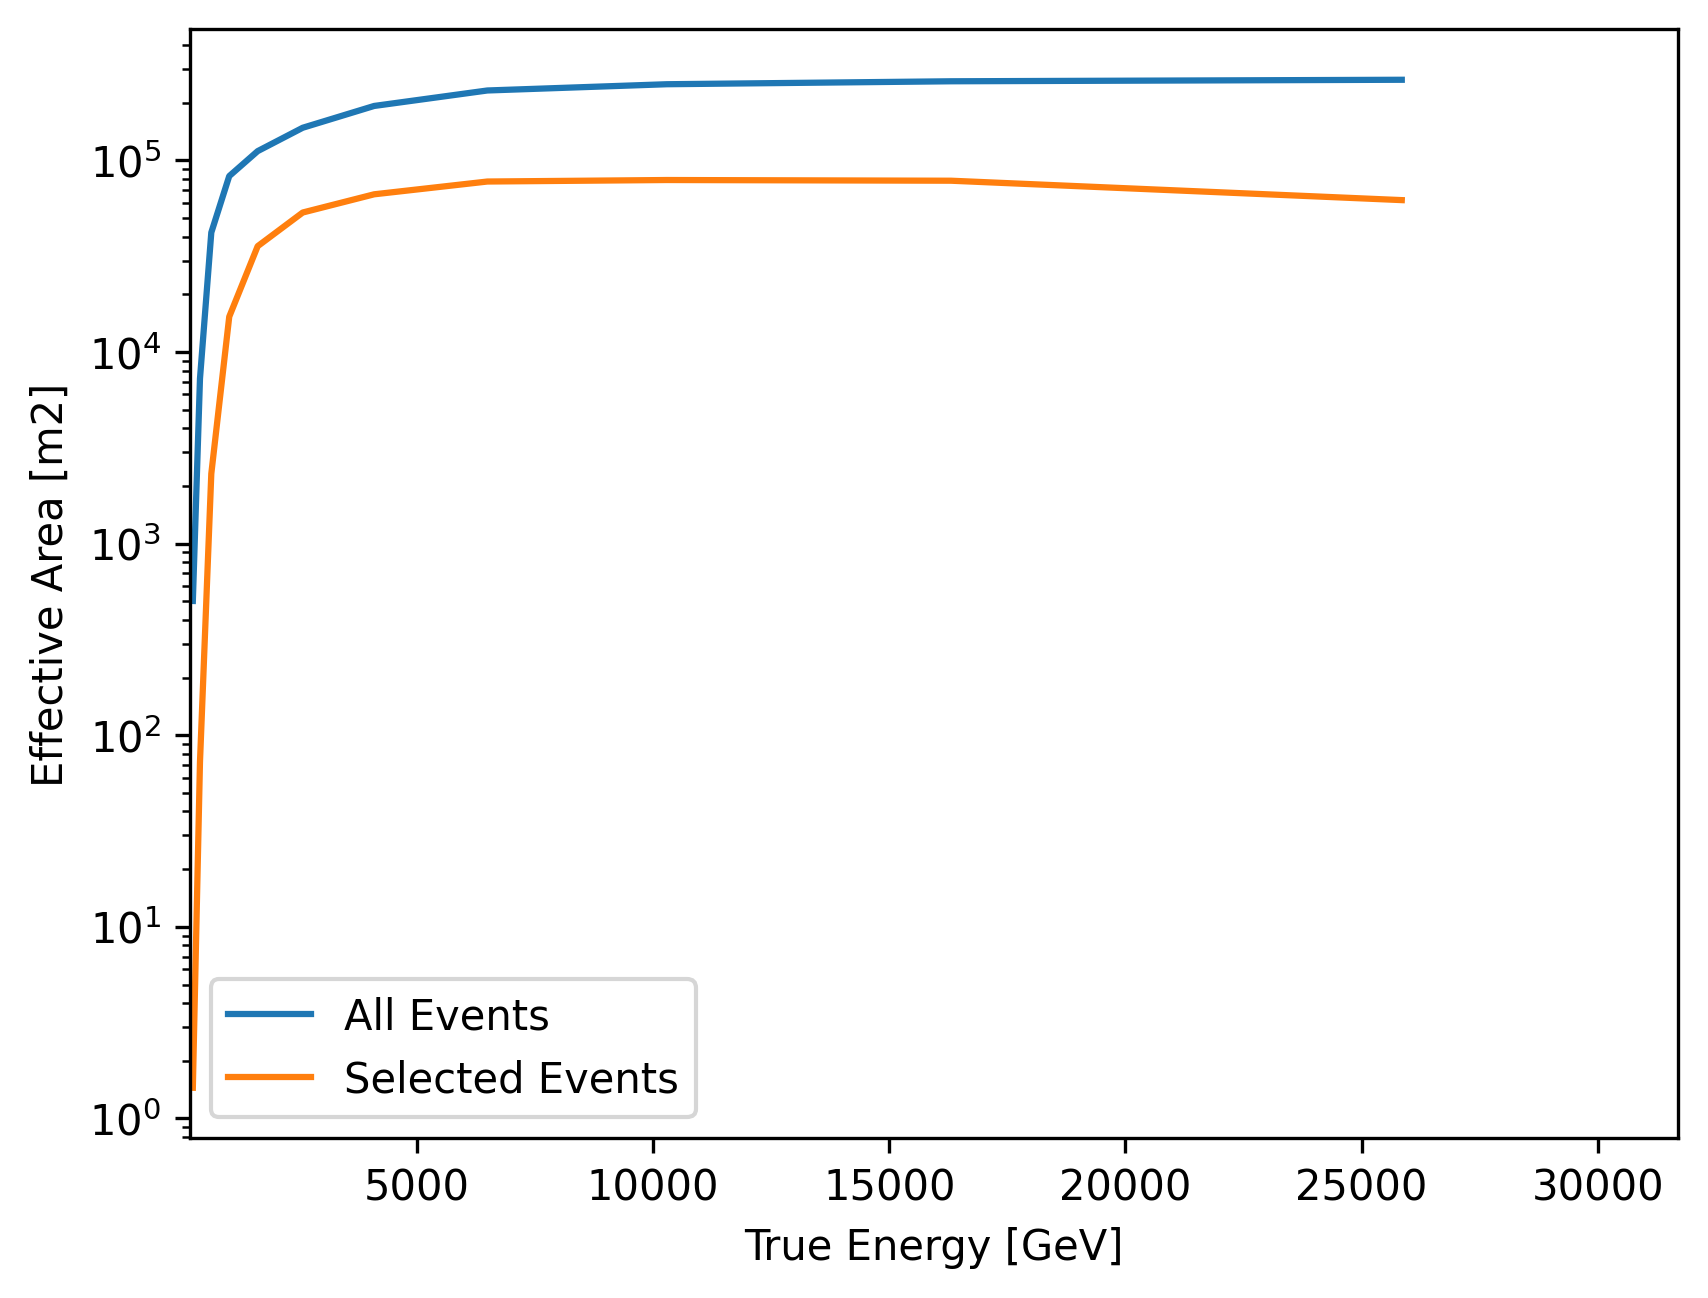

In [12]:
# utility function to converet pyirf Quantities to the gammapy classes
from pyirf.gammapy import create_effective_area_table_2d

plt.figure()

for aeff, label in zip((aeff_all, aeff_selected), ('All Events', 'Selected Events')):
    aeff_gammapy = create_effective_area_table_2d(
        # add a new dimension for the single fov offset bin
        effective_area=aeff[..., np.newaxis],
        true_energy_bins=true_energy_bins,
        fov_offset_bins=fov_offset_bins,
    )


    aeff_gammapy.plot_energy_dependence(label=label, offset=[wobble_offset])

plt.xlim(true_energy_bins.min().to_value(u.GeV), true_energy_bins.max().to_value(u.GeV))    
plt.yscale('log')
plt.legend()

print(aeff_gammapy)

### Point Spread Function

The point spread function describes how well the direction of the gamma rays is estimated.

In [13]:
from pyirf.irf import psf_table
from pyirf.utils import calculate_source_fov_offset


gammas['true_source_fov_offset'] = calculate_source_fov_offset(gammas)


source_offset_bins = np.linspace(0, 3, 100) * u.deg

# calculate this only for the events after the gamma/hadron separation
psf = psf_table(gammas[gammas['selected_gh']], true_energy_bins, source_offset_bins, fov_offset_bins)

In [14]:
psf.shape

(11, 1, 99)

Again, let's use gammapy to plot:

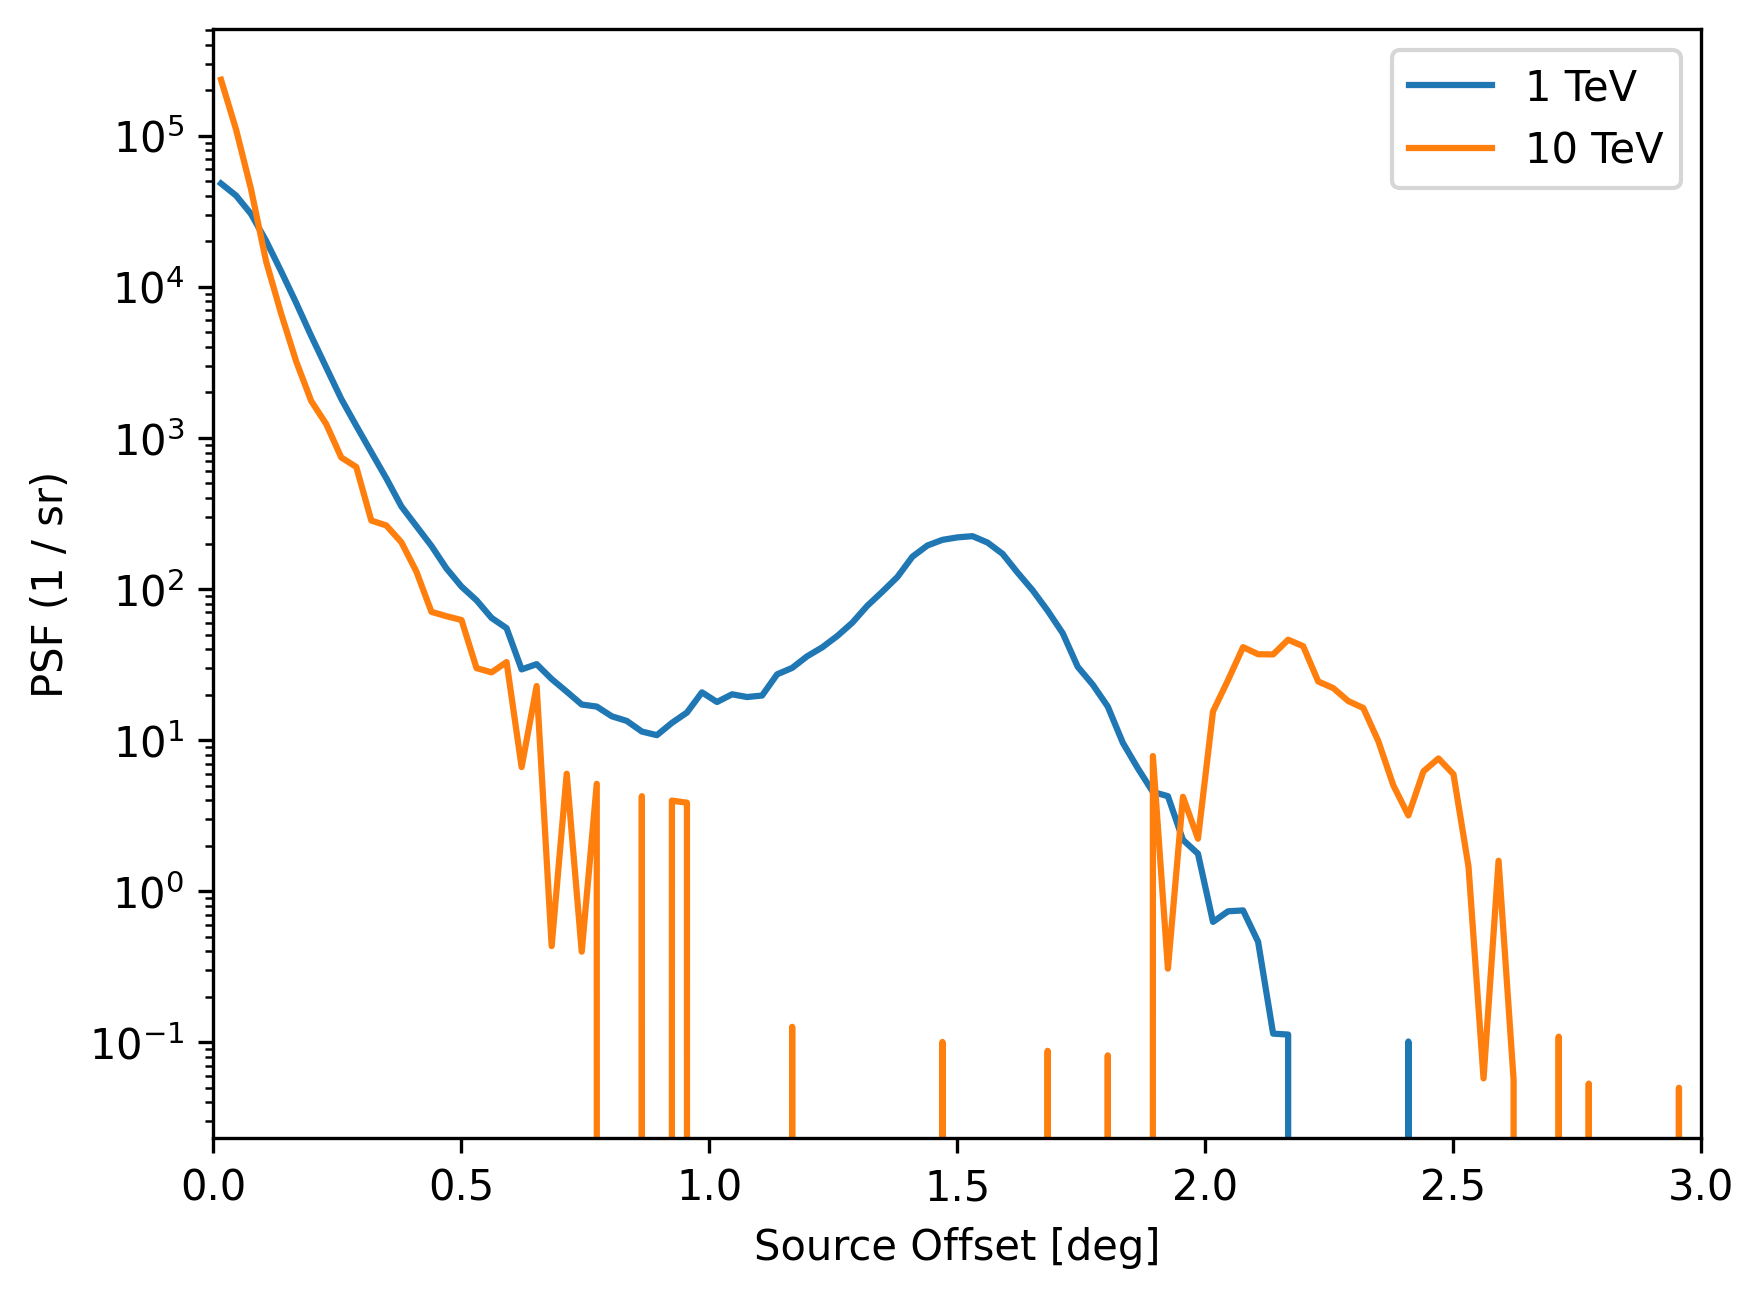

In [15]:
from pyirf.gammapy import create_psf_3d

psf_gammapy = create_psf_3d(psf, true_energy_bins, source_offset_bins,  fov_offset_bins)

plt.figure()
psf_gammapy.plot_psf_vs_rad(offset=[wobble_offset], energy_true=[1., 10.]*u.TeV)
plt.legend(plt.gca().lines, ['1 TeV', '10 TeV'])

### Energy Dispersion

Describes how well the energy is estimated

In [16]:
from pyirf.irf import energy_dispersion

# logarithmic space, is "symmetric" in terms of ratios 0.1 is a factor of 10 from 1 is a factor of 10 from 10
migration_bins = np.geomspace(0.1, 10, 100)

edisp = energy_dispersion(
    gammas[gammas['selected']],
    true_energy_bins=true_energy_bins,
    fov_offset_bins=fov_offset_bins,
    migration_bins=migration_bins,
)

Plot edisp

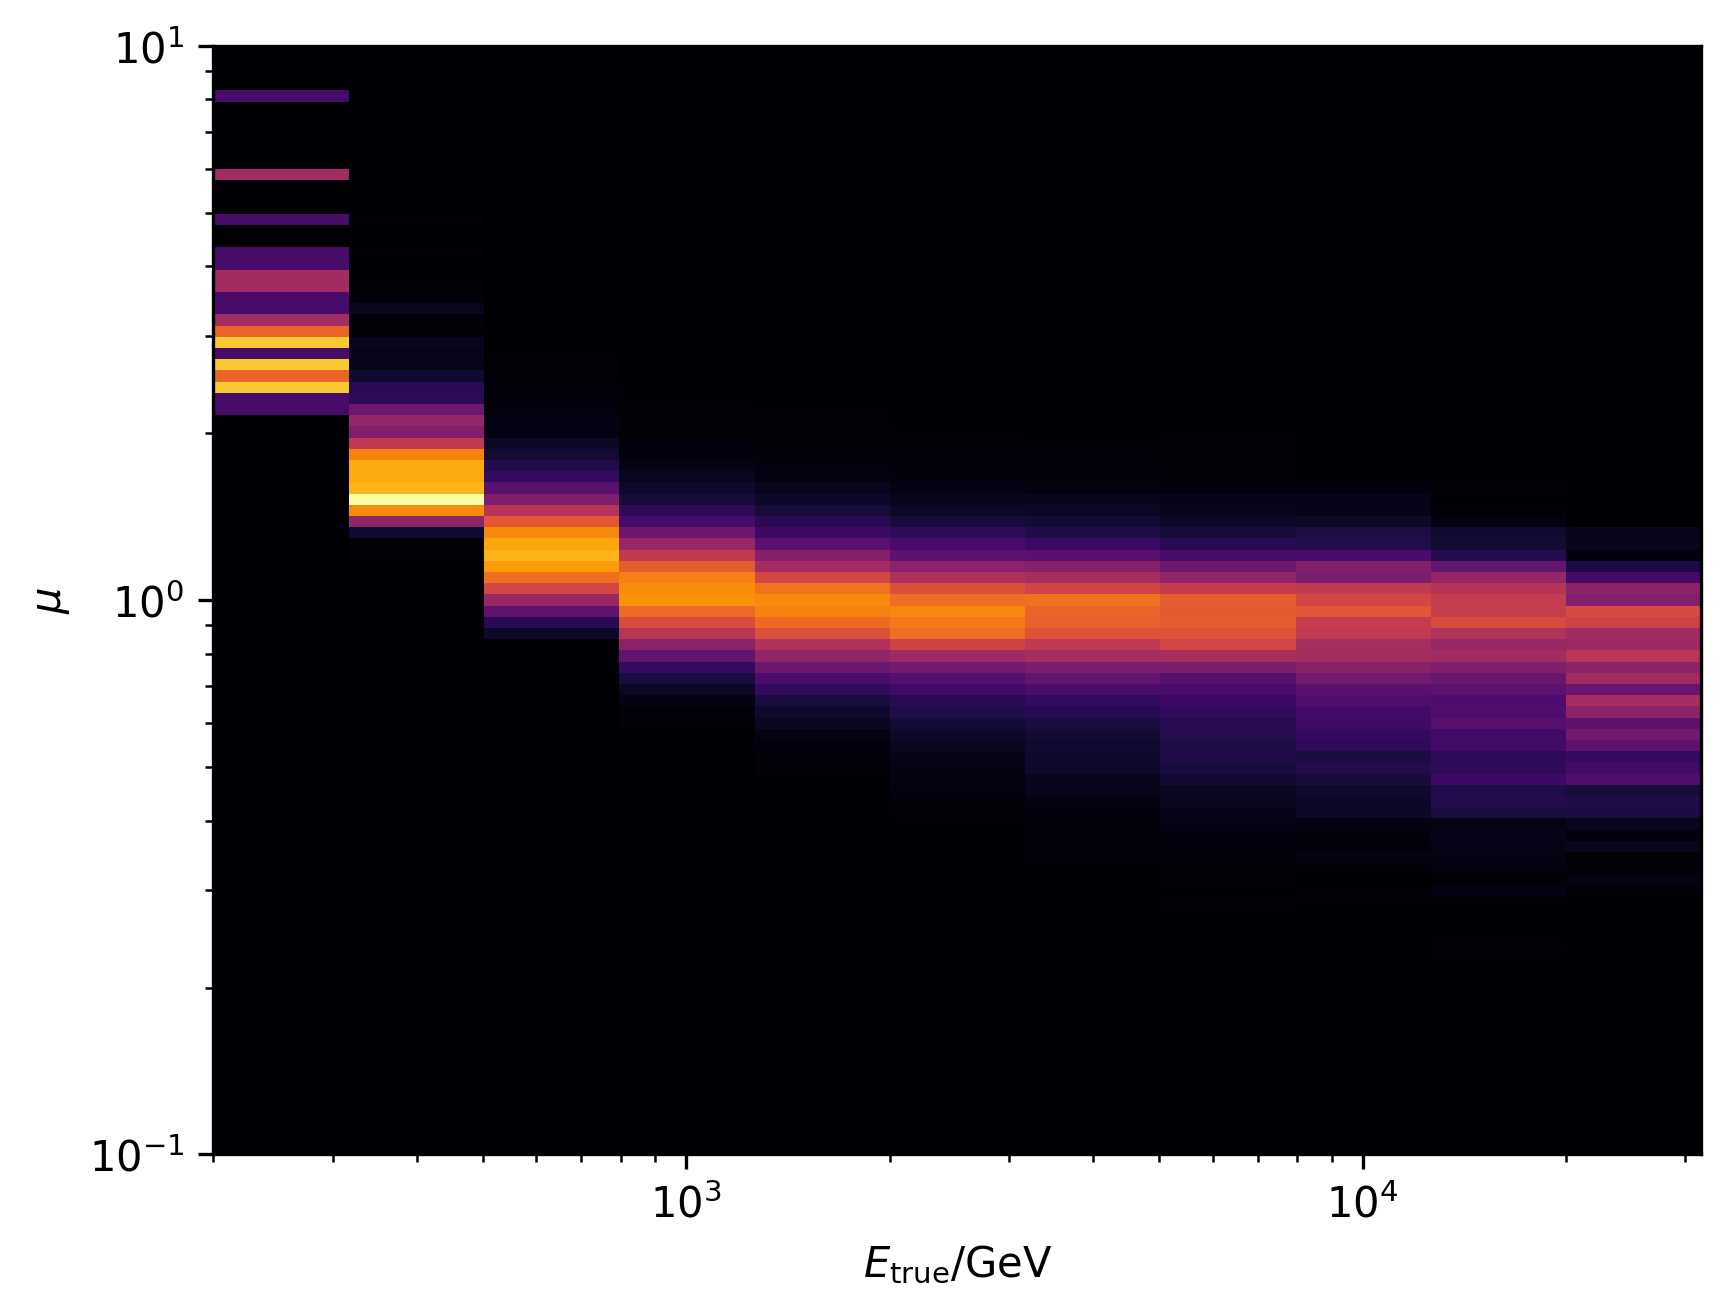

In [17]:
from gammapy.irf import EnergyDispersion2D

plt.figure()
plt.pcolormesh(
    true_energy_bins.to_value(u.GeV),
    migration_bins,
    edisp[:, :, 0].T,
    cmap='inferno'
)

plt.xlabel('$E_\mathrm{true} / \mathrm{GeV}$')
plt.ylabel('$\mu$')
plt.yscale('log')
plt.xscale('log')

## Export to GADF FITS files

We use the classes and methods from `astropy.io.fits` and `pyirf.io.gadf` to write files following the GADF 
specification, which can be found here:

https://gamma-astro-data-formats.readthedocs.io/en/latest/

In [18]:
from pyirf.io.gadf import create_aeff2d_hdu, create_energy_dispersion_hdu, create_psf_table_hdu
from astropy.io import fits
from astropy.time import Time
from pyirf import __version__

# set some common meta data for all hdus
meta = dict(
    CREATOR='pyirf-v' + __version__,
    TELESCOP='FACT',
    INSTRUME='FACT',
    DATE=Time.now().iso,
)

hdus = []

# every fits file has to have an Image HDU as first HDU.
# GADF only uses Binary Table HDUs, so we need to add an empty HDU in front
hdus.append(fits.PrimaryHDU(header=fits.Header(meta)))

hdus.append(create_aeff2d_hdu(aeff_selected, true_energy_bins, fov_offset_bins, **meta))
hdus.append(create_energy_dispersion_hdu(edisp, true_energy_bins, migration_bins, fov_offset_bins, **meta))
hdus.append(create_psf_table_hdu(psf, true_energy_bins,    source_offset_bins, fov_offset_bins, **meta))

fits.HDUList(hdus).writeto('fact_irf.fits.gz', overwrite=True)